In [15]:
import os
import glob
import json
import pymworks
import re
import numpy as np
import pandas as pd
import seaborn as sns
import pylab as pl
import cPickle as pkl

from scipy import stats

In [16]:
%matplotlib inline

In [17]:
# raw_dir = '/Users/julianarhee/Documents/coxlab/projects/old_data/gonogo_bluesquare_thresholdv2/raw'
# animalid = 'T6'

# tmpdfns = glob.glob(os.path.join(raw_dir, animalid, '*.mwk'))
# tmpdfn = tmpdfns[0]
# tmpdf = pymworks.open(tmpdfn)


In [18]:

def atoi(text):
    return int(text) if text.isdigit() else text

def natural_keys(text):
    return [ atoi(c) for c in re.split('(\d+)', text) ]


In [19]:
def parse_datafile_name(dfn):
    fn = os.path.splitext(os.path.split(dfn)[-1])[0]
    fparts = fn.split('_')

    assert len(fparts) == 2, "*Warning* Unknown naming fmt: %s" % str(fparts)
    animalid = fparts[0]
    datestr = fparts[1]

    # Make sure no exra letters are in the datestr (for parta, b, etc.)
    if not datestr.isdigit():
        datestr = re.split(r'\D', datestr)[0] # cut off any letter suffix
    if len(datestr) == 6:
        session = '20%s' % datestr 
    elif len(datestr) == 8:
        session = datestr 

    return animalid, session


In [20]:

def get_run_time(df):
    state_modes = df.get_events('#state_system_mode')
    
    running = next(d for d in state_modes if d.value==2)
    start_time = running.time

    strt = state_modes.index(running)
    try:
        stopping = next(d for d in state_modes[strt:] if d.value != 2) 
        end_time = stopping.time
    except StopIteration:
        end_time = df.get_maximum_time()

    run_bounds = (start_time, end_time)

    return run_bounds

In [21]:
def parse_trials(df, resp_types=[], remove_orphans=True):
    boundary = get_run_time(df)

    tmp_devs = df.get_events('#stimDisplayUpdate')                      # get *all* display update events
    tmp_devs = [i for i in tmp_devs if boundary[0] <= i['time']<= boundary[1]] #\
                #]                                 # only grab events within run-time bounds (see above)

    dimmed = df.get_events('FlagDimTarget')
    dimmed = np.mean([i.value for i in dimmed])                         # set dim flag to separate trials based on initial stim presentation

#     resptypes = ['correct_lick','correct_ignore',\
#                     'bad_lick','bad_ignore']
#                      #,\ # 'aborted_counter']                           # list of response variables to track...

    outevs = df.get_events(resp_types)                                   # get all events with these vars
    outevs = [i for i in outevs if i['time']<= boundary[1] and\
                i['time']>=boundary[0]]
    R = sorted([r for r in outevs if r.value > 0], key=lambda e: e.time)

    T = pymworks.events.display.to_trials(tmp_devs, R,\
                remove_unknown=False)                                   # match stim events to response events

    if dimmed:                                                          # don't double count stimulus for "faded" target stimuli
        trials = [i for i in T if 'alpha_multiplier' not in i.keys() or i['alpha_multiplier']==1.0]
    else:
        trials = T

    print "N total response events: ", len(trials)
    if remove_orphans:                                                  # this should always be true, generally...
        orphans = [(i,x) for i,x in enumerate(trials) if\
                    x['outcome']=='unknown']
        trials = [t for t in trials if not t['outcome']=='unknown']     # get rid of display events without known outcome within 'duration_multiplier' time
        print "Found and removed %i orphan stimulus events in file %s"\
                    % (len(orphans), df.filename)
        print "N valid trials: %i" % len(trials)

    return trials


## Parse trials (for each datafile) into session data

In [22]:
def get_session_data(dfns, resp_types=[], remove_orphans=True, n_training_phases=5):
    
    sesssions_per_phase = dict((p, []) for p in range(n_training_phases))
    session_dict = {}
    for dfn in sorted(dfns, key=natural_keys):
        aid, datestr = parse_datafile_name(dfn)
#         if aid != animalid: #self.name:
#             continue

        if datestr in session_dict.keys():
            if not isinstance(session_dict[datestr]['datasource'], list):
                session_dict[datestr]['datasource'] = [session_dict[datestr]['datasource']]
            session_dict[datestr]['datasource'].append(dfn)
        else:
            session_dict[datestr] = dict()
            session_dict[datestr]['datasource'] = dfn 

        # Open datafile:
        df = pymworks.open(dfn)

        # Get current session info:
        phases_completed = list(set([d.value for d in df.get_events('phases_completed') if d.value <= n_training_phases]))
        server_address = df.get_events('#serialBridgeAddress')[-1].value
        server_name = df.get_events('#serverName')[-1].value

        # Parse trials:
        trials = parse_trials(df, resp_types=resp_types, remove_orphans=remove_orphans)

        # Update session dict:
        if 'trials' in session_dict[datestr].keys():
            session_dict[datestr]['trials'].extend(trials)
        else:
            session_dict[datestr]['trials'] = trials

        session_dict[datestr]['server'] = {'address': server_address, 'name': server_name}

        # Add session to corresponding phase:
        for p in phases_completed:
            sesssions_per_phase[int(p)].append(datestr)
    
    return session_dict, sesssions_per_phase
    

In [23]:
from scipy.stats import norm
from math import exp,sqrt
Z = norm.ppf
 
def dPrime(hits, misses, fas, crs):
    # Floors an ceilings are replaced by half hits and half FA's
    halfHit = 0.5/(hits+misses)
    halfFa = 0.5/(fas+crs)
 
    # Calculate hitrate and avoid d' infinity
    hitRate = hits/(hits+misses)
    if hitRate == 1: hitRate = 1-halfHit
    if hitRate == 0: hitRate = halfHit
 
    # Calculate false alarm rate and avoid d' infinity
    faRate = fas/(fas+crs)
    if faRate == 1: faRate = 1-halfFa
    if faRate == 0: faRate = halfFa
 
    # Return d', beta, c and Ad'
    out = {}
    out['d'] = Z(hitRate) - Z(faRate)
    out['beta'] = exp((Z(faRate)**2 - Z(hitRate)**2)/2)
    out['c'] = -(Z(hitRate) + Z(faRate))/2
    out['Ad'] = norm.cdf(out['d']/sqrt(2))
    return out

# Classes

In [24]:
class SessionData():
    
    def __init__(self, trials, datestr='', source_data=[], phase=None, server_info={}):
        self.datestr = datestr
        self.source_data = source_data
        self.server_address = server_info['address']
        self.server_name = server_info['name']
        self.training_phase = phase
        
        self.start_time = sorted(trials, key=lambda x: x['time'])[0]['time']
        self.end_time = sorted(trials, key=lambda x: x['time'])[-1]['time'] \
                        + sorted(trials, key=lambda x: x['time'])[-1]['duration']
        self.ntrials = len(trials)
        self.trials = trials
        
        self.stats = struct()
        
        self.get_session_stats() # Populates struct w/ fields counts, rates, dprime 

    def get_session_stats(self):
        self.stats.counts = self.get_outcome_counts_gonogo()
        self.stats.rates = self.counts_to_rates_gonogo()
        self.stats.dprime = self.calculate_dprime()
        
        
    def get_outcome_counts_gonogo(self):

        hits = [t for t in self.trials if t['outcome'] == 'correct_lick']
        misses = [t for t in self.trials if t['outcome'] == 'bad_ignore']
        fas = [t for t in self.trials if t['outcome'] == 'bad_lick']
        crs = [t for t in self.trials if t['outcome'] == 'correct_ignore']

        n_target_present = len(hits) + len(misses)
        n_target_absent = len(fas) + len(crs)

        n_hits = len(hits)
        n_misses = len(misses)
        n_fas = len(fas)
        n_crs = len(crs)

        counts = {'hits': 1E-9 if n_target_present==0 else float(n_hits), 
                  'misses': 1E-9 if n_target_present==0 else float(n_misses), 
                  'fas': 1E-9 if n_target_absent==0 else float(n_fas), 
                  'crs': 1E-9 if n_target_absent==0 else float(n_crs),
                  'n_target_present': 1E-9 if n_target_present==0 else n_target_present,
                  'n_target_absent': 1E-9 if n_target_absent==0 else n_target_absent}

        return counts

    def counts_to_rates_gonogo(self):
        fa_rate = self.stats.counts['fas'] / self.stats.counts['n_target_absent']
        cr_rate = self.stats.counts['crs'] / self.stats.counts['n_target_absent']
        hit_rate = self.stats.counts['hits'] / self.stats.counts['n_target_present']
        miss_rate = self.stats.counts['misses'] / self.stats.counts['n_target_present']

        rates = {'fas': fa_rate, 
                 'crs': cr_rate,
                 'hits': hit_rate,
                 'misses': miss_rate}

        return rates
    
    def calculate_dprime(self):
        results = dPrime(self.stats.counts['hits'], self.stats.counts['misses'], \
                         self.stats.counts['fas'], self.stats.counts['crs'])
        return results
            
        

In [25]:
class struct():
    pass

class Animal():
    def __init__(self, name, rootdir, experiment='', resp_types=[]):
        self.name = name
        self.experiment = experiment
        self.datafiles = glob.glob(os.path.join(rootdir, name, '*.mwk'))
        self.resp_types = resp_types
        
        self.sessions = []     # Populated by get_sessions()
        self.stats = struct()  # Populated by get_stats()
        
        self.stats.bad_sampling = None # TODO: if N signal+noise or noise-only trials too small, extreme values...
        self.stats.counts = None
        self.stats.rates = None
        self.stats.dprime = None
        
    def get_sessions(self, resp_types=[], remove_orphans=True, n_training_phases=5, verbose=False):
        '''
        For each session / datafile, get session info and parse trials. Combine partials, if relevant.
        '''
        if len(resp_types) == 0:
            if 'gonogo' in experiment:
                resp_types = ['hits', 'misses', 'crs', 'fas']
            else:
                resp_types = ['success', 'failure', 'ignore']
        self.resp_types = resp_types
        
        # Parse sessions into trials and get training phase:
        dfns = self.datafiles
        session_dict, sesssions_per_phase = get_session_data(dfns, resp_types=resp_types,
                                                             remove_orphans=remove_orphans, 
                                                             n_training_phases=n_training_phases)
        # For each parsed session, create SessionData() object:
        self.sessions = []
        for datestr, sdict in sorted(session_dict.items(), key=lambda x: x[0]):
            source_data = sdict['datasource'] if isinstance(sdict['datasource'], list) else [sdict['datasource']]
            phase = [ph for ph, dfs in sesssions_per_phase.items() if datestr in dfs][0] + 1
            server_info = sdict['server']

            if verbose:
                print "%s: Ph. %i -- %i trials (%i dfiles)" % (datestr, phase, len(sdict['trials']), len(source_data))

            if len(sdict['trials']) == 0:
                continue
            self.sessions.append(SessionData(sdict['trials'], 
                                           datestr=datestr,
                                           source_data=source_data,
                                           phase=phase,
                                           server_info=server_info))
        #self.sessions = sessiondata

    def get_stats(self, min_samples=30, filter_sampling=False):
        self.stats.counts = self.get_counts_by_session()
        self.stats.rates = self.get_rates_by_session(min_samples=min_samples, filter_sampling=filter_sampling)
        self.stats.dprime = self.get_dprime_by_session()
        
    def get_counts_by_session(self):
        sdict = {}
        for s in self.sessions:
            sdict[s.datestr] = s.stats.counts
        DF = pd.DataFrame(sdict).T
        return DF
    
    def get_rates_by_session(self, min_samples=30, filter_sampling=False):
        bad_sampling = []
        if filter_sampling:
            bad_sampling = [s for s in self.stats.counts.index.tolist() \
                                if self.stats.counts.loc[s]['n_target_present'] <= min_samples]
            self.stats.bad_sampling = bad_sampling
            print "Excluding %i sessions (too few signal trials)" % len(bad_sampling)
            
        sdict = {}
        for s in self.sessions:
            if s.datestr in bad_sampling:
                continue
            sdict[s.datestr] = s.stats.rates
        DF = pd.DataFrame(sdict).T
            
        return DF

    def get_dprime_by_session(self):
        sdict = {}
        for s in self.sessions:
            if s.datestr in self.stats.bad_sampling:
                continue
            sdict[s.datestr] = s.stats.dprime
        DF = pd.DataFrame(sdict).T
        return DF
    

    def plot_rates_by_session(self, ax=None, legend=False, colors=[], cmap="cubehelix",
                             linestyle='-', marker='o', markersize=12, excluded=[]):
        if ax is None:
            fig, ax = pl.subplots()
        session_names = sorted(self.stats.rates.index.tolist(), key=natural_keys)
        session_names = [s for s in session_names if s in included]
            
        resp_types = self.stats.rates.columns.tolist()
        if len(resp_types) != len(colors):
            #print "Not enough colors specified. Using default cmap for %i resp_types." % len(resp_types)
            colors = sns.color_palette(cmap, len(resp_types))
            
        for ri, resp in enumerate(resp_types):
            curr_values = [self.stats.rates.loc[sess][resp] for sess in session_names] # sessions should be in order
            ax.plot(curr_values, linestyle=linestyle, color=colors[ri], label=resp)
        ax.set_xlabel('session')
        ax.set_ylabel('percent')
        ax.set_title(animalid)
        if legend:
            ax.legend()
        
    def plot_dprime_by_session(self, ax=None, color='cornflowerblue',
                              linestyle='-', linewidth=3, marker='o', markersize=12):
        if ax is None:
            fig, ax = pl.subplots()
            
        session_names = sorted(self.stats.rates.index.tolist(), key=natural_keys)
        dprime_values = [self.stats.dprime.loc[sess]['d'] for sess in session_names]
        pl.plot(dprime_values, color=color, ls=linestyle, lw=linewidth, marker=marker, markersize=markersize)
        pl.xlabel('session')
        pl.ylabel('dprime')
        pl.title(animalid)



# Analyze training data

In [72]:
raw_dir = '/Users/julianarhee/Documents/coxlab/projects/old_data/gonogo_bluesquare_thresholdv2/raw'
animalids = [r for r in os.listdir(raw_dir) if os.path.isdir(os.path.join(raw_dir, r))]
print animalids

experiment = 'gonogo_bluesquare'
n_training_phases = 5
remove_orphans = True
min_samples=30
filter_sampling=True

resp_types = ['correct_lick','correct_ignore', 'bad_lick','bad_ignore']
base_dir = os.path.split(raw_dir)[0]
output_dir = os.path.join(base_dir, 'parsed')
if not os.path.exists(output_dir): os.makedirs(output_dir)
    

['T1', 'T2', 'T3', 'T4', 'T5', 'T6']


In [73]:
print output_dir

/Users/julianarhee/Documents/coxlab/projects/old_data/gonogo_bluesquare_thresholdv2/parsed


### Specify parsing params, create Animal() objects

In [75]:
R = {}

for aix, animalid in enumerate(sorted(animalids, key=natural_keys)):
    print "***[%s] processing %i of %i rats." % (animalid, aix+1, len(animalids))
    animal_outfile = os.path.join(output_dir, '%s.pkl' % animalid)
    if os.path.exists(animal_outfile):
        print "Loading existing animal data file..."
        with open(animal_outfile, 'rb') as f:
            R[animalid] = pkl.load(f)
    else:
        #### Create new animal object:
        R[animalid] = Animal(animalid, raw_dir, experiment=experiment)
        #### Parse all sessions into trials and outcome types
        R[animalid].get_sessions(resp_types=resp_types, remove_orphans=remove_orphans, n_training_phases=n_training_phases)
    
    #### Calculate stats for plotting
    R[animalid].get_stats(min_samples=min_samples, filter_sampling=filter_sampling)
        
    with open(animal_outfile, 'wb') as f:
        pkl.dump(R[animalid], f, protocol=pkl.HIGHEST_PROTOCOL)

print "DONE!"

***[T1] processing 1 of 6 rats.
Loading existing animal data file...
Excluding 6 sessions (too few signal trials)
***[T2] processing 2 of 6 rats.
Loading existing animal data file...
Excluding 13 sessions (too few signal trials)
***[T3] processing 3 of 6 rats.
Loading existing animal data file...
Excluding 7 sessions (too few signal trials)
***[T4] processing 4 of 6 rats.
Loading existing animal data file...
Excluding 5 sessions (too few signal trials)
***[T5] processing 5 of 6 rats.
Loading existing animal data file...
Excluding 8 sessions (too few signal trials)
***[T6] processing 6 of 6 rats.
Loading existing animal data file...
Excluding 2 sessions (too few signal trials)
DONE!


### Plot performance rates of each outcome type by session

In [103]:
linestyle='-'
colors = sns.color_palette('cubehelix', len(resp_types))

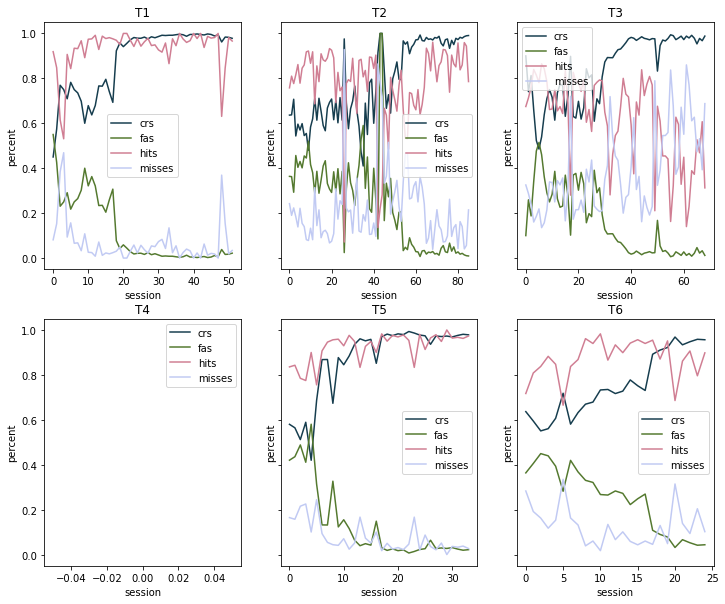

In [104]:
fig, axes = pl.subplots(2,3, figsize=(12,10), sharex=False, sharey=True)
for animalid, ax in zip(sorted(R.keys(), key=natural_keys), axes.flat):
    session_names = sorted([s.datestr for s in R[animalid].sessions if s.training_phase >= 3 \
                           and s.datestr in R[animalid].stats.rates.index.tolist()], key=natural_keys)
    
    resp_types = R[animalid].stats.rates.columns.tolist()
    for ri, resp in enumerate(resp_types):
        curr_values = [R[animalid].stats.rates.loc[sess][resp] for sess in session_names] # sessions should be in order
        ax.plot(curr_values, linestyle=linestyle, color=colors[ri], label=resp)
    ax.set_xlabel('session')
    ax.set_ylabel('percent')
    ax.set_title(animalid)
    if legend:
        ax.legend()

#### Plot all phases (doesn't really make sense to plot before all trial types available)

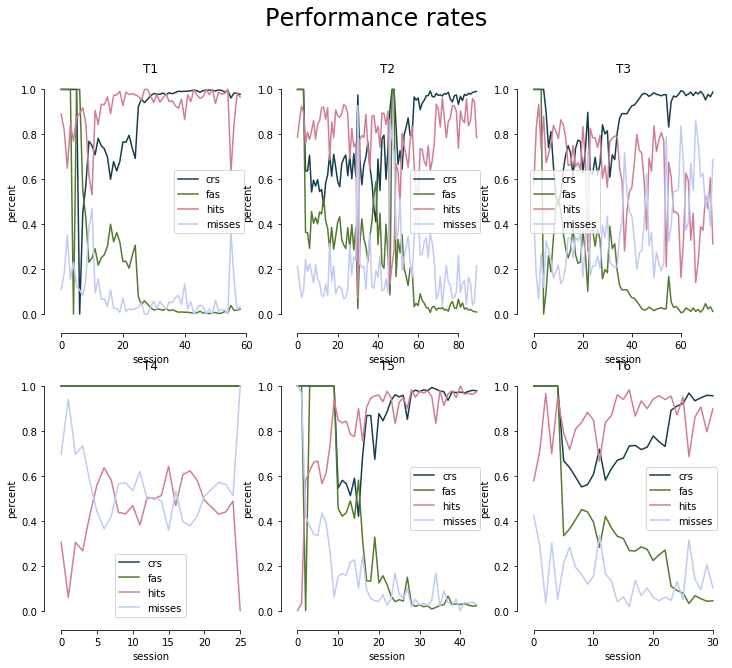

In [105]:
fig, axes = pl.subplots(2,3, figsize=(12,10), sharex=False, sharey=True)
for animalid, ax in zip(sorted(R.keys(), key=natural_keys), axes.flat):
    R[animalid].plot_rates_by_session(ax=ax, legend=legend, cmap=cmap, linestyle='-', markersize=0)

sns.despine(trim=True, offset=8)
pl.suptitle('Performance rates', fontsize=24)

# Population figures

### Plot performance rates of each outcome type by session 
##### Dual-axis?  (d' and ntrials by session?) - RT?

In [106]:
excluded = ['T4']
included = [r for r in R.keys() if r not in excluded]
rat_colors = sns.color_palette("colorblind", len(included))


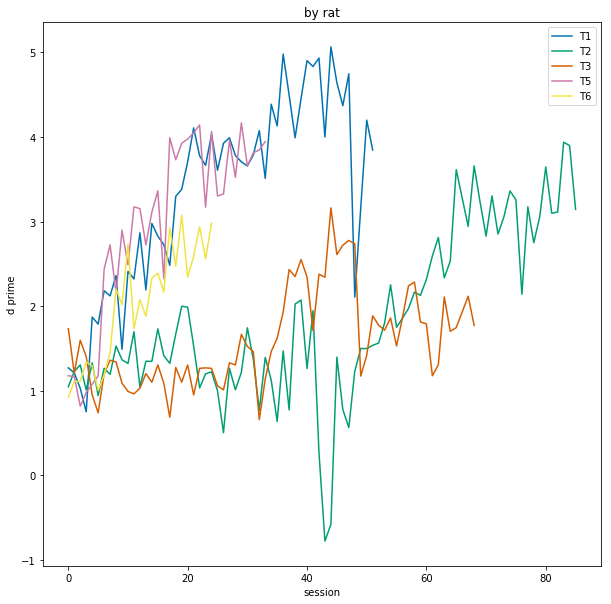

In [108]:
fig, ax = pl.subplots(1, figsize=(10,10))
for aix, animalid in enumerate(sorted(included, key=natural_keys)):
    if animalid=='T4':
        continue
    #R[animalid].plot_dprime_by_session(ax=ax, markersize=0, color=rat_colors[aix])
    
    session_names = sorted([s.datestr for s in R[animalid].sessions if s.training_phase >= 3 \
                           and s.datestr in R[animalid].stats.rates.index.tolist()], key=natural_keys)
    dprime_values = [R[animalid].stats.dprime.loc[sess]['d'] for sess in session_names]
    
    ax.plot(dprime_values, color=rat_colors[aix], label=animalid)
pl.ylabel('d prime')
pl.xlabel('session')
pl.title('by rat')
pl.legend()

In [94]:
hits = [t for t in trials if t['outcome'] == 'correct_lick']
misses = [t for t in trials if t['outcome'] == 'bad_ignore']
false_alarms = [t for t in trials if t['outcome'] == 'bad_lick']
correct_rejects = [t for t in trials if t['outcome'] == 'correct_ignore']

print "**************************"
print "Summary:"
print "**************************"
print "Hits: %i" % len(hits)
print "Misses: %i" % len(misses)
print "FAs: %i" % len(false_alarms)
print "Corr Rejections: %i" % len(correct_rejects)

**************************
Summary:
**************************
Hits: 88
Misses: 10
FAs: 66
Corr Rejections: 1445
